In [18]:
import eurostat
code_renewables = 'nrg_inf_epcrw'  # Electricity production capacities for renewables and wastes
code_other = 'nrg_inf_epc'    # Electricity production capacities by main fuel groups and operator
pars_renewables = eurostat.get_pars(code_renewables)
pars_other = eurostat.get_pars(code_other)
pars_renewables, pars_other

(['freq', 'siec', 'plant_tec', 'unit', 'geo'],
 ['freq', 'siec', 'plant_tec', 'operator', 'unit', 'geo'])

In [19]:
descriptions_renewables = {}
for par in pars_renewables:
    par_values = eurostat.get_par_values(code_renewables, par)
    dic = eurostat.get_dic(code_renewables, par)
    tempdict = {}
    for flag, description in dic:
        if(flag in par_values):
            tempdict[flag] = description
    descriptions_renewables[par] = tempdict
data_renewables = eurostat.get_data(code_renewables)

In [20]:
descriptions_other = {}
for par in pars_other:
    par_values = eurostat.get_par_values(code_other, par)
    dic = eurostat.get_dic(code_other, par)
    tempdict = {}
    for flag, description in dic:
        if(flag in par_values):
            tempdict[flag] = description
    descriptions_other[par] = tempdict
data_other = eurostat.get_data(code_other)

In [67]:
from collections import defaultdict 
descriptions = defaultdict(dict) 
for name in descriptions_other.keys():
    for tip, descript in descriptions_other[name].items():
        descriptions[name][tip] = descript
    if name != 'operator':
        for tip, descript in descriptions_renewables[name].items():
            descriptions[name][tip] = descript

In [65]:

def what_is(descriptor):
    for name, description in descriptions.items():
        if descriptor in description:
            return f'{name}     {descriptor} : {descriptions[name][descriptor]}', 
    return f'{descriptor} does not exsist'

In [74]:
what_is('X9900')

('siec     X9900 : Other fuels n.e.c.',)

In [24]:
countries_only_in_renewables = set(descriptions_renewables['geo'].keys()) - set(descriptions_other['geo'].keys())
countries_only_in_renewables

{'BA', 'GE', 'IS', 'MD', 'UA', 'UK', 'XK'}

In [25]:
import pandas as pd
columns = list(data_other[0])
columns[5] = 'geo'
pandas_data_other = pd.DataFrame(data_other[1:], columns=columns)

columns = list(data_renewables[0])
columns[4] = 'geo'
pandas_data_renewables = pd.DataFrame(data_renewables[1:], columns=columns)

pandas_data_other

,freq,siec,plant_tec,operator,unit,geo,1990,1991,1992,1993,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,A,CF,CAP_NET_ELC,PRR_AUTO,MW,AL,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.000,0.000
1,A,CF,CAP_NET_ELC,PRR_AUTO,MW,AT,996.0,1003.0,1003.0,1019.0,...,1844.0,1723.0,1701.0,1712.0,1341.011,1288.054,1784.427,1828.885,1933.275,1531.757
2,A,CF,CAP_NET_ELC,PRR_AUTO,MW,BE,745.0,762.0,754.0,728.0,...,1351.0,1399.0,1321.0,1228.1,1345.000,1418.200,1615.800,1681.000,1703.600,1880.700
3,A,CF,CAP_NET_ELC,PRR_AUTO,MW,BG,0.0,0.0,0.0,0.0,...,65.0,60.0,137.0,187.0,234.396,234.417,160.770,155.458,171.050,213.035
4,A,CF,CAP_NET_ELC,PRR_AUTO,MW,CY,0.0,0.0,0.0,0.0,...,36.0,32.0,41.0,37.0,37.120,36.918,29.718,29.718,30.218,23.308
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3083,A,X9900,CAP_NET_ELC_DCM,PRR_MAIN,MW,RS,NaN,NaN,NaN,NaN,...,NaN,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.000,0.000
3084,A,X9900,CAP_NET_ELC_DCM,PRR_MAIN,MW,SE,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000,0.000,0.000,0.000
3085,A,X9900,CAP_NET_ELC_DCM,PRR_MAIN,MW,SI,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000
3086,A,X9900,CAP_NET_ELC_DCM,PRR_MAIN,MW,SK,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000,0.000,0.000,0.000


In [26]:
pandas_data_renewables

,freq,siec,plant_tec,unit,geo,1990,1991,1992,1993,1994,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,A,R5100,CAP_NET_ELC,MW,AL,0.0,0.0,0.0,0.0,0.0,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1,A,R5100,CAP_NET_ELC,MW,AT,400.0,400.0,400.0,412.0,412.0,...,1017.352,958.884,938.621,916.695,837.771,824.253,813.428,816.199,764.702,784.199
2,A,R5100,CAP_NET_ELC,MW,BA,NaN,NaN,NaN,NaN,NaN,...,NaN,0.000,0.000,0.000,0.000,0.250,1.220,1.120,9.220,9.220
3,A,R5100,CAP_NET_ELC,MW,BE,26.0,26.0,18.0,11.0,11.0,...,640.000,557.600,591.300,566.300,559.200,526.300,539.200,563.500,448.000,488.600
4,A,R5100,CAP_NET_ELC,MW,BG,0.0,0.0,0.0,0.0,0.0,...,30.000,30.000,34.000,19.000,22.973,33.019,23.513,15.064,13.914,15.100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2298,A,W6200,CAP_NET_ELC,MW,SK,0.0,0.0,0.0,0.0,0.0,...,5.000,11.000,11.000,19.000,12.000,12.000,12.000,12.000,12.000,13.000
2299,A,W6200,CAP_NET_ELC,MW,TR,0.0,0.0,0.0,0.0,0.0,...,0.000,0.000,0.000,0.000,0.000,2.499,4.499,4.600,108.470,108.470
2300,A,W6200,CAP_NET_ELC,MW,UA,0.0,0.0,0.0,0.0,0.0,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,NaN,NaN
2301,A,W6200,CAP_NET_ELC,MW,UK,31.0,31.0,45.0,50.0,87.0,...,545.000,680.000,929.940,1028.285,1090.933,1136.727,1321.434,NaN,NaN,NaN


In [27]:
import numpy as np
is_PRODUCING = pandas_data_other['operator'] == 'PRR_MAIN'
is_SI = pandas_data_other['geo'] == 'SI'
is_ACTIVE =  pandas_data_other['plant_tec'] == 'CAP_NET_ELC'
condition = np.logical_and(is_PRODUCING, is_ACTIVE)
condition = np.logical_and(condition, is_SI)
pandas_data_other.loc[condition]

,freq,siec,plant_tec,operator,unit,geo,1990,1991,1992,1993,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
69,A,CF,CAP_NET_ELC,PRR_MAIN,MW,SI,0.0,0.0,1060.0,1010.0,...,1214.0,1192.0,1086.0,1272.0,1285.774,1467.478,1467.816,1470.529,1528.811,1527.271
285,A,N9000,CAP_NET_ELC,PRR_MAIN,MW,SI,0.0,0.0,632.0,632.0,...,688.0,688.0,688.0,688.0,688.000,688.000,688.000,688.000,688.000,688.000
501,A,RA100,CAP_NET_ELC,PRR_MAIN,MW,SI,728.0,728.0,728.0,728.0,...,1183.0,1180.0,1179.0,1177.0,1230.926,1227.716,1230.090,1230.273,1230.305,1224.228
573,A,RA110,CAP_NET_ELC,PRR_MAIN,MW,SI,728.0,728.0,728.0,728.0,...,1003.0,1000.0,999.0,997.0,1050.926,1047.716,1050.090,1050.273,1050.305,1044.228
789,A,RA120,CAP_NET_ELC,PRR_MAIN,MW,SI,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.000,0.000
1005,A,RA130,CAP_NET_ELC,PRR_MAIN,MW,SI,0.0,0.0,0.0,0.0,...,180.0,180.0,180.0,180.0,180.000,180.000,180.000,180.000,180.000,180.000
1221,A,RA200,CAP_NET_ELC,PRR_MAIN,MW,SI,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.000,0.000
1437,A,RA300,CAP_NET_ELC,PRR_MAIN,MW,SI,0.0,0.0,0.0,0.0,...,2.0,3.0,3.0,3.0,3.300,3.300,3.300,3.300,3.328,3.328
1509,A,RA310,CAP_NET_ELC,PRR_MAIN,MW,SI,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000
1725,A,RA320,CAP_NET_ELC,PRR_MAIN,MW,SI,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000


In [28]:
# my_filter_pars = {'geo': ['SI'] , 'siec' : [ 'RA100', 'RA110','RA110ROR', 'RA120', 'RA130']}
# my_filter_pars = {'geo': ['SI'] , 'siec' : [ 'RA100', 'RA110', 'RA120', 'RA130']}
# data = eurostat.get_data(code, filter_pars=my_filter_pars)
# data[1:]

In [29]:
import matplotlib
import matplotlib.pyplot as plt

my_filter_pars = {'geo': ['SI'] , 'siec' : [ 'RA100', 'RA110','RA110ROR', 'RA120', 'RA130']}
my_filter_pars = {'geo': ['SI'] , 'siec' : [ 'RA100', 'RA110', 'RA120', 'RA130']}
data = eurostat.get_data(code_renewables, filter_pars=my_filter_pars)

In [30]:

my_filter_pars = {'geo' : list(descriptions['geo'].keys())[2:] ,'siec' : 'W6100'}
# my_filter_pars = {'geo' : ['IS'] ,'siec' : 'RA110ROR'}
data = eurostat.get_data(code_renewables, filter_pars=my_filter_pars)

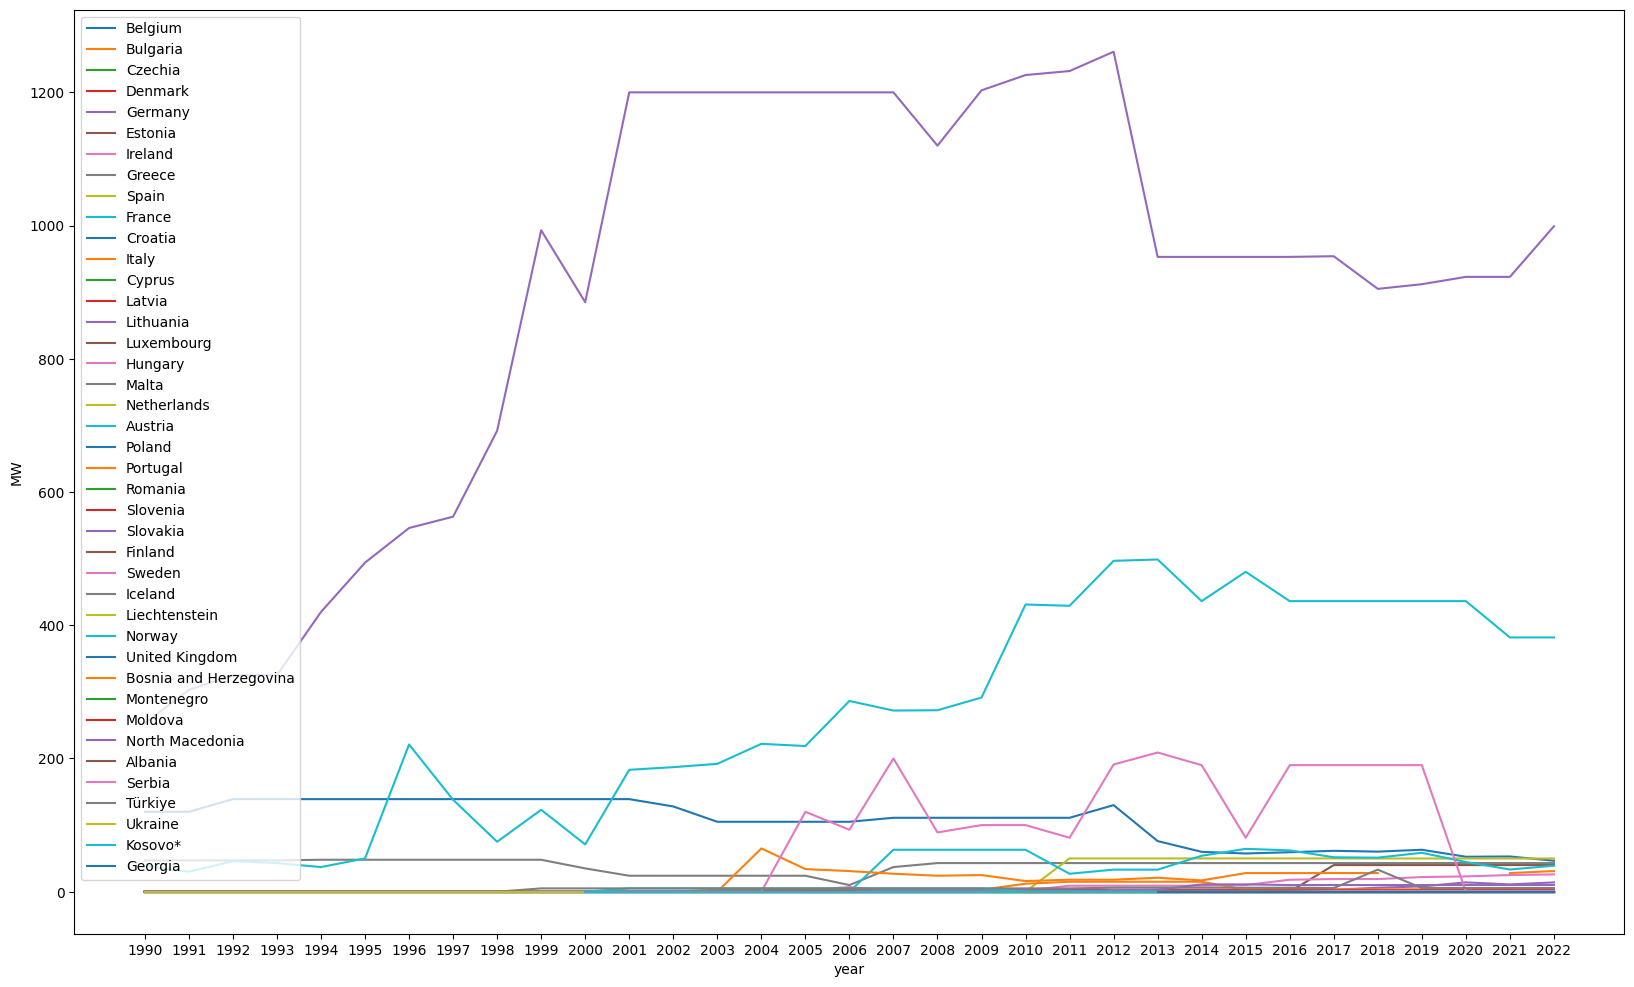

In [31]:
plt.figure(figsize=(20, 12))
# for i in range(1, len(data)):
#     plt.plot(data[0][5:], data[i][5:], label = str(descriptions['geo'][data[i][4]]))
for i in range(1, len(data)):
    plt.plot(data[0][5:], data[i][5:], label = str(descriptions['geo'][data[i][4]]))
plt.xlabel('year')
plt.ylabel('MW')

plt.legend();

In [32]:
# my_filter_pars = {'geo' : ['NO', 'FR', 'DE'] ,'siec' : 'W6100'}
# data = eurostat.get_data(code, filter_pars=my_filter_pars)

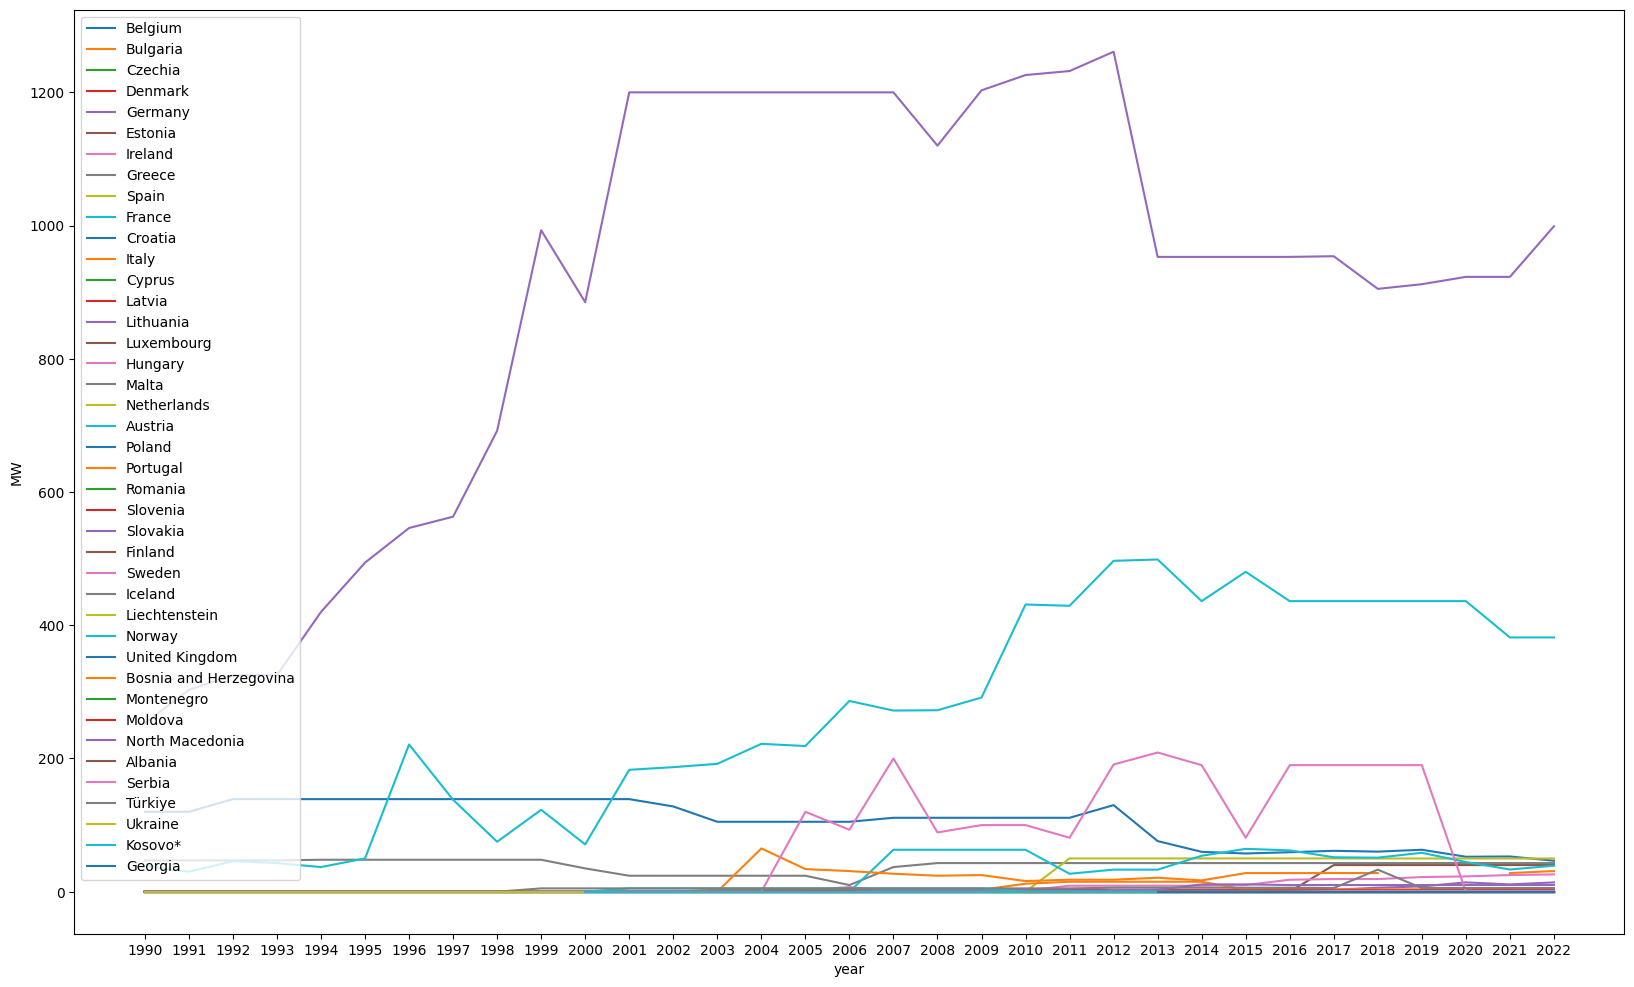

In [33]:
plt.figure(figsize=(20, 12))
for i in range(1, len(data)):
    plt.plot(data[0][5:], data[i][5:], label = str(descriptions['geo'][data[i][4]]))
plt.xlabel('year')
plt.ylabel('MW')

plt.legend();